In [7]:
# adapted from https://github.com/yunjey/show-attend-and-tell/blob/master/evaluate_model.ipynb
import torch
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable
from feat_data_loader import *
from extract_feature import get_transform
from attention_models import Decoder, EncoderVGG
from helper import *
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 12.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'



ImportError: No module named 'pandas'

In [2]:
transform = get_transform()
name = 'train'
train_table      = pd.read_pickle(os.path.join('.','{}_table.pkl'.format(name)))	
train_captions   = train_table.caption
captions   = [caption for caption in train_captions]
name          = 'val'
val_table     = pd.read_pickle(os.path.join('.','{}_table.pkl'.format(name)))	
val_captions   = val_table.caption
val_captions   = [caption for caption in val_captions]
captions.extend(val_captions)
vocab = build_vocab(captions, threshold=0)

In [31]:
data_loader =  get_loader(data_dir='data', 
                          name = 'train', 
                          feature_path = 'data/mit1003.pth', 
                          batch_size=2,
                          shuffle=False, 
                          num_workers=2)


In [32]:

model_path = 'models/vgg_model.pth' # the vgg16 net that only have layers of [0~28] in feature module
encoder_path = 'models/attn_model.pth' # the trained model


In [33]:
encoder = EncoderVGG(model_path)
decoder = torch.load(encoder_path)

encoder = encoder.cuda()
encoder.eval()
decoder = decoder.cuda()
decoder.eval()

Decoder(
  (embed): Embedding(155, 512)
  (dropout): Dropout(p=0.5)
  (lstm_cell): LSTMCell(1024, 512, bias=1)
  (fc_dropout): Dropout(p=0.5)
  (fc_out): Linear(in_features=512, out_features=155, bias=True)
  (att_vw): Linear(in_features=512, out_features=512, bias=False)
  (att_hw): Linear(in_features=512, out_features=512, bias=False)
  (att_w): Linear(in_features=512, out_features=1, bias=False)
)

In [34]:
names = []
captions = []
alphas = []
for i, (image, name) in enumerate(dataloader):
    image = Variable(image).cuda()
    fea = encoder(image)
    fea = fea.view(fea.size(0), 512, 196).transpose(1, 2)
    ids, weights = decoder.sample(fea)
    names.append(name)
    captions.append(ids)
    alphas.append(weights)
    if (i+1)%20 == 0:
        break

/home/ubuntu/Lung-Disease-Detection-Project/models.py:252: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = nn.Softmax()(att_out)


['normal', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']


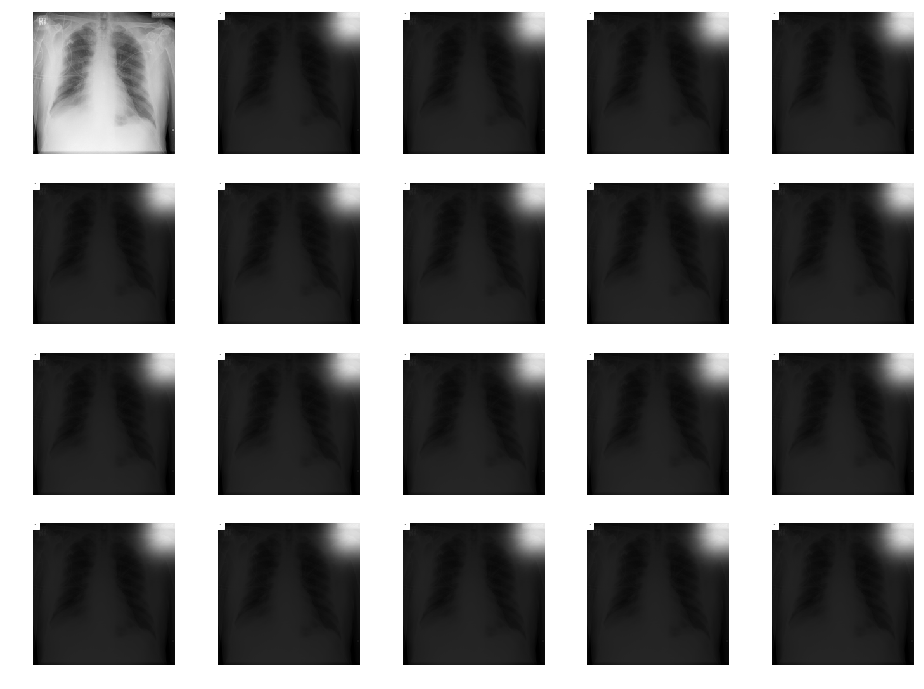

In [36]:
idx = 16
alps = torch.cat(alphas[idx][1:], 0)
cap = decode_captions(captions[idx].data.cpu().view(1, -1), vocab.idx2word)[0]
print(cap)
attention_visualization(root, names[idx][0], cap, alps.data.cpu())
idx += 1